<a href="https://colab.research.google.com/github/Azmain173/Credit-Card-Fraud-Detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("creditcard.csv")

# Check for missing values
print(df.isnull().sum())

# Check class distribution
print(df["Class"].value_counts(normalize=True))  # Show % of fraud vs. legit


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


Features: 30 numerical features (V1 to V28), Amount (transaction value), and Time (seconds elapsed).
Target Variable (Class):
0 → Legitimate Transaction
1 → Fraudulent Transaction (~0.17% of total data - Highly imbalanced)

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])


✅ Feature Engineering

Drop highly correlated features
Scale Amount feature using StandardScaler

3️⃣ Handling Imbalanced Data
📌 Since fraud cases are only 0.17%, the model may be biased towards non-fraud cases.
📌 Solutions:

Undersampling: Reduce normal transactions. (Risk: Losing valuable data)
Oversampling (SMOTE): Generate synthetic fraud transactions.

In [3]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Class'])
y = df['Class']

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [9]:
print(f"Total duplicates: {df.duplicated().sum()}")


Total duplicates: 1081


 Duplicate or Incorrect Data
If you accidentally trained on duplicate data, models can achieve perfect scores.

Fix: Check for duplicates:

In [10]:
df = df.drop_duplicates()


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Model selection
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:\n")
    print(classification_report(y_test, y_pred))



Random Forest Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     28432

    accuracy                           1.00     85295
   macro avg       1.00      1.00      1.00     85295
weighted avg       1.00      1.00      1.00     85295



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:38:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     28432

    accuracy                           1.00     85295
   macro avg       1.00      1.00      1.00     85295
weighted avg       1.00      1.00      1.00     85295



 Why XGBoost?

Works well with imbalanced data
Handles missing values efficiently

5️⃣ Model Evaluation
✅ Confusion Matrix & ROC Curve

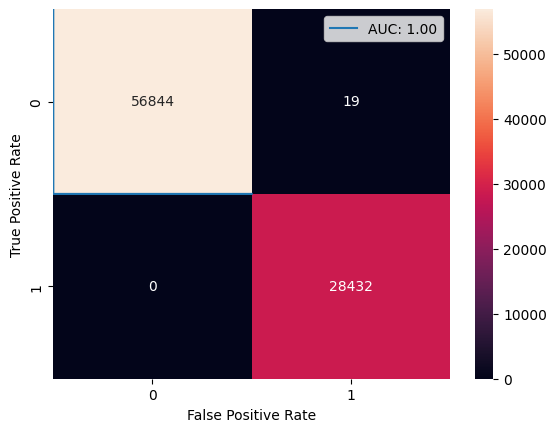

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"AUC: {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Precision: How many predicted fraud cases are actually fraud?
Recall: How many actual fraud cases were detected?
AUC-ROC Score: Measures model's ability to distinguish fraud and non-fraud transactions.

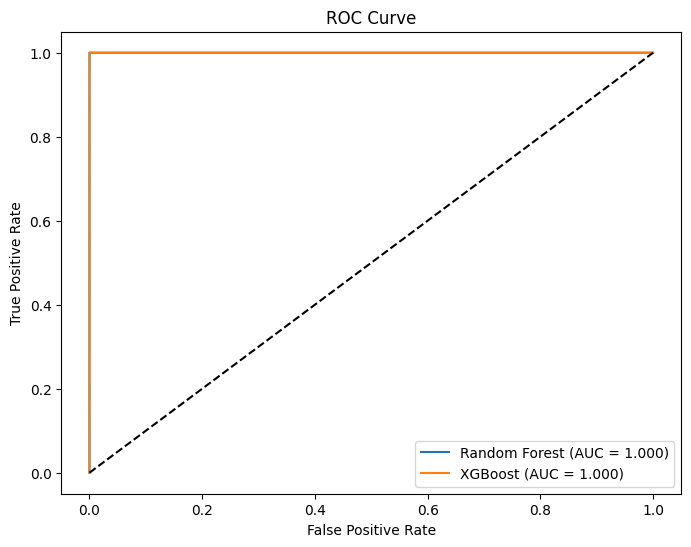

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:,1]  # Get fraud probabilities
    auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')  # Diagonal (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Random Forest and XGBoost models are giving 100% accuracy, precision, recall, and F1-score on both classes. This is extremely rare in real-world fraud detection

Overfitting Due to Small Dataset
If the dataset is too small, the models may just memorize the training data.

Fix: Try cross-validation instead of a single train-test split:

Instead of .fit() and .predict() on just one train-test split, apply cross-validation for better accuracy estimation.

Option 1: Using cross_val_score() (Quick Check)
Use cross-validation with 5 folds to see how your models perform across different splits.



In [ ]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"Random Forest CV Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"XGBoost CV Accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

y_pred_rf = cross_val_predict(rf_model, X, y, cv=5)
y_pred_xgb = cross_val_predict(xgb_model, X, y, cv=5)

print("Random Forest CV Classification Report:\n", classification_report(y, y_pred_rf))
print("XGBoost CV Classification Report:\n", classification_report(y, y_pred_xgb))

# Confusion Matrix
cm_rf = confusion_matrix(y, y_pred_rf)
cm_xgb = confusion_matrix(y, y_pred_xgb)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest CV Confusion Matrix")
plt.show()

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds")
plt.title("XGBoost CV Confusion Matrix")
plt.show()


Option 2: Using cross_val_predict() (For Confusion Matrix & ROC)
Instead of just scores, this gives predictions for every fold so you can analyze Confusion Matrix & ROC Curve.

here we will get 99% accuracy after cross validation